In [3]:
import random
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
# ----------------------------------------------------------------------------------
# 1. Data Preprocessing Function
# ----------------------------------------------------------------------------------
def preprocess_data(df):
    # Derive occupancy from lights
    df['Occupancy'] = df['lights'].apply(lambda x: 1 if x > 0 else 0)
    
    # Calculate average indoor temperature (T1 through T9)
    temp_cols = [f'T{i}' for i in range(1, 10)]
    df['Avg_T1_T9'] = df[temp_cols].mean(axis=1)
    
    # Calculate HVAC energy consumption (Appliances minus lights)
    df['HVAC_energy'] = df['Appliances'] - df['lights']
    
    # Extract hour of day from date
    df['date'] = pd.to_datetime(df['date'])
    df['Hour_of_day'] = df['date'].dt.hour
    
    # Select relevant features
    relevant_features = ['Avg_T1_T9', 'T_out', 'Occupancy', 'Hour_of_day', 'HVAC_energy']
    df = df[relevant_features].copy()

    # Forward fill missing values
    df.ffill(inplace=True)
    return df

In [5]:
# ----------------------------------------------------------------------------------
# 2. HVAC Environment (with dynamic indoor temperature & reward scaling)
# ----------------------------------------------------------------------------------
class HVACEnvironment:
    def __init__(self, dataframe, desired_temperature=22):
        self.df = dataframe.copy()
        self.desired_temperature = desired_temperature  
        self.observation_space_shape = self.df.shape[1]  # Number of features
        self.action_space_n = 4  # (Off, Low, Medium, High)
        self.current_step = 0
        self.max_steps = len(self.df) - 1

        self.energy_thresholds = {
            'Low': self.df['HVAC_energy'].quantile(0.25),
            'Medium': self.df['HVAC_energy'].quantile(0.5),
            'High': self.df['HVAC_energy'].quantile(0.75)
        }
        
        # CHANGE 1: Initialize mutable indoor temperature.
        self.current_temp = self.df['Avg_T1_T9'].iloc[0]

    def reset(self, start_step=0):
        self.current_step = start_step
        # CHANGE 2: Reset indoor temperature.
        self.current_temp = self.df['Avg_T1_T9'].iloc[self.current_step]
        return self._get_state()

    def _get_state(self):
        # CHANGE 3: Use the updated indoor temperature.
        row = self.df.iloc[self.current_step].copy()
        row['Avg_T1_T9'] = self.current_temp
        return row.values

    def _get_reward(self, action, simulated_energy):
        # We further scale down the reward (divide by 1000 instead of 100)
        lambda_factor = 1  
        reward = -(simulated_energy + lambda_factor * abs(self.current_temp - self.desired_temperature)) / 1000.0
        return reward

    def _take_action(self, action):
        # Simulate energy consumption ranges:
        if action == 0:  # Off
            hvac_energy = np.random.uniform(0, 25)
        elif action == 1:  # Low
            hvac_energy = np.random.uniform(25, 100)
        elif action == 2:  # Medium
            hvac_energy = np.random.uniform(100, 300)
        elif action == 3:  # High
            hvac_energy = np.random.uniform(300, 500)
        else:
            raise ValueError("Invalid action.")
        return hvac_energy

    def step(self, action):
        simulated_energy = self._take_action(action)
        
        # CHANGE 4: Update the indoor temperature dynamically.
        temp_change = (self.desired_temperature - self.current_temp) * 0.05
        self.current_temp += temp_change * (simulated_energy / 500.0)

        self.current_step += 1
        next_state = self._get_state()
        reward = self._get_reward(action, simulated_energy)
        done = self.current_step >= self.max_steps
        return next_state, reward, done, {"HVAC_energy": simulated_energy}

In [6]:
# ----------------------------------------------------------------------------------
# 3. DQN Model Components
# ----------------------------------------------------------------------------------
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return map(np.array, zip(*batch))
    
    def __len__(self):
        return len(self.buffer)

In [7]:
# ----------------------------------------------------------------------------------
# 4. DQN Agent (with a lower learning rate and robust learn() implementation)
# ----------------------------------------------------------------------------------
class DQNAgent:
    def __init__(self, state_size, action_size, device):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device

        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 1e-5  
        self.batch_size = 64
        self.update_target_every = 5

        self.q_network = QNetwork(state_size, action_size).to(device)
        self.target_network = QNetwork(state_size, action_size).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        self.memory = ReplayBuffer(10000)

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_size)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.q_network(state_tensor)
        return int(torch.argmax(q_values, dim=1).item())

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        loss_value = None
        if len(self.memory) > self.batch_size:
            loss_value = self.learn()
        return loss_value

    def learn(self):
        # Enable anomaly detection.
        torch.autograd.set_detect_anomaly(True)

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones.astype(np.uint8)).unsqueeze(1).to(self.device)

        # Check for NaNs in inputs.
        if torch.isnan(states).any():
            print("NaN in states!")
        if torch.isnan(rewards).any():
            print("NaN in rewards!")
        if torch.isnan(next_states).any():
            print("NaN in next_states!")

        q_values = self.q_network(states).gather(1, actions)
        with torch.no_grad():
            max_next_q_values = self.target_network(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards + self.gamma * max_next_q_values * (1 - dones)

        # Clamp Q-values to avoid exploding numbers.
        q_values = torch.clamp(q_values, -100.0, 100.0)
        target_q_values = torch.clamp(target_q_values, -100.0, 100.0)

        loss = nn.MSELoss()(q_values, target_q_values)
        if torch.isnan(loss):
            print("Loss is NaN!")
            print("q_values:", q_values)
            print("target_q_values:", target_q_values)
            return 0.0

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()
        return loss.item()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

In [8]:
# ----------------------------------------------------------------------------------
# 5. Training Functions
# ----------------------------------------------------------------------------------
def train_dqn(env, agent, n_episodes=1000, max_t=500):
    scores = []
    train_metrics = []  # List of dictionaries storing per-episode metrics
    train_losses = [] 
    overall_start_time = time.time()
    
    for episode in range(1, n_episodes + 1):
        ep_start_time = time.time()
        state = env.reset()
        total_reward = 0.0
        t = 0
        done = False
        episode_losses = []
        baseline_energy_sum = 0.0
        rl_energy_sum = 0.0
        temp_deviation_sum = 0.0
        
        while not done and t < max_t:
            baseline_energy_sum += state[-1]
            temp_deviation_sum += abs(state[0] - env.desired_temperature)
            
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            loss = agent.step(state, action, reward, next_state, done)
            if loss is not None:
                episode_losses.append(loss)
            state = next_state
            total_reward += reward
            rl_energy_sum += info.get("HVAC_energy", 0.0)
            t += 1

        if episode % agent.update_target_every == 0:
            agent.update_target_network()
        
        ep_end_time = time.time()  # Episode end time
        ep_duration = ep_end_time - ep_start_time
            
        avg_loss = np.mean(episode_losses) if episode_losses else float('nan')
        energy_savings = baseline_energy_sum - rl_energy_sum
        avg_temp_deviation = temp_deviation_sum / t if t > 0 else 0.0
        cost_savings = energy_savings * 0.10
        
        print(f"Episode {episode:3d} | Steps: {t:3d} | Total Reward: {total_reward:9.2f} | "
              f"Avg Loss: {avg_loss:8.4f} | Epsilon: {agent.epsilon:6.3f} | Time: {ep_duration:6.2f} sec")
        print(f"    Energy Savings (Wh): {energy_savings:8.2f} | Temp Deviation: {avg_temp_deviation:6.2f} | "
              f"Cost Savings ($): {cost_savings:6.2f}")
        
        if agent.epsilon > agent.epsilon_min:
            agent.epsilon *= agent.epsilon_decay
        scores.append(total_reward)
        train_metrics.append({
            "episode": episode,
            "steps": t,
            "total_reward": total_reward,
            "avg_loss": avg_loss,
            "epsilon": agent.epsilon,
            "energy_savings": energy_savings,
            "avg_temp_deviation": avg_temp_deviation,
            "cost_savings": cost_savings
        })
        
    overall_end_time = time.time()  # End overall timer
    total_training_time = overall_end_time - overall_start_time
    print(f"Total training time: {total_training_time:.2f} seconds")
    
    return scores, train_metrics, train_losses


In [9]:
# =============================================================================
# 7. Evaluation Function for DQN - Compute and Print Final Average Metrics
# =============================================================================
def evaluate_dqn(env, agent, n_episodes=10, max_t=500, C_energy=0.10):
    results = []
    for episode in range(1, n_episodes + 1):
        state = env.reset()
        total_reward = 0.0
        t = 0
        baseline_energy_sum = 0.0
        rl_energy_sum = 0.0
        temp_deviation_sum = 0.0
        done = False
        while not done and t < max_t:
            baseline_energy_sum += state[-1]
            temp_deviation_sum += abs(state[0] - env.desired_temperature)
            action = agent.act(state)
            state, reward, done, info = env.step(action)
            total_reward += reward
            rl_energy_sum += info.get("HVAC_energy", 0.0)
            t += 1
        energy_savings = baseline_energy_sum - rl_energy_sum
        avg_temp_deviation = temp_deviation_sum / t if t > 0 else 0.0
        cost_savings = energy_savings * C_energy

        print(f"Eval Episode {episode:3d} | Steps: {t:3d} | Total Reward: {total_reward:9.2f}")
        print(f"    Energy Savings (Wh): {energy_savings:8.2f} | Temp Deviation: {avg_temp_deviation:6.2f} | "
              f"Cost Savings ($): {cost_savings:6.2f}")
        
        results.append({
            "episode": episode,
            "steps": t,
            "total_reward": total_reward,
            "energy_savings": energy_savings,
            "avg_temp_deviation": avg_temp_deviation,
            "cost_savings": cost_savings
        })
    # Compute final aggregated metrics over all evaluation episodes.
    avg_reward = np.mean([r["total_reward"] for r in results])
    avg_energy_savings = np.mean([r["energy_savings"] for r in results])
    avg_temp_deviation = np.mean([r["avg_temp_deviation"] for r in results])
    avg_cost_savings = np.mean([r["cost_savings"] for r in results])
    
    print("\nFinal Average Evaluation Metrics over all evaluation episodes:")
    print(f"Avg Total Reward: {avg_reward:.2f}")
    print(f"Avg Energy Savings (Wh): {avg_energy_savings:.2f}")
    print(f"Avg Temperature Deviation: {avg_temp_deviation:.2f}")
    print(f"Avg Cost Savings ($): {avg_cost_savings:.2f}")
    
    return results

In [10]:
# ----------------------------------------------------------------------------------
# 7. Plotting Functions for Training and Evaluation Metrics
# ----------------------------------------------------------------------------------
def plot_training_metrics(train_metrics, train_losses):
    episodes = [m['episode'] for m in train_metrics]
    total_rewards = [m['total_reward'] for m in train_metrics]
    avg_losses = [m['avg_loss'] for m in train_metrics]
    epsilons = [m['epsilon'] for m in train_metrics]
    energy_savings = [m['energy_savings'] for m in train_metrics]
    avg_temp_deviations = [m['avg_temp_deviation'] for m in train_metrics]
    cost_savings = [m['cost_savings'] for m in train_metrics]

    plt.figure(figsize=(14, 10))
    
    # Plot Total Reward, Epsilon, Energy Savings and Cost Savings on one figure.
    plt.subplot(2, 2, 1)
    plt.plot(episodes, total_rewards, marker='o', label='Total Reward')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward vs Episode')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(episodes, epsilons, marker='o', color='red', label='Epsilon')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title('Epsilon vs Episode')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(episodes, energy_savings, marker='o', color='green', label='Energy Savings (Wh)')
    plt.xlabel('Episode')
    plt.ylabel('Energy Savings (Wh)')
    plt.title('Energy Savings vs Episode')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(episodes, cost_savings, marker='o', color='purple', label='Cost Savings ($)')
    plt.xlabel('Episode')
    plt.ylabel('Cost Savings ($)')
    plt.title('Cost Savings vs Episode')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(episodes, avg_losses, marker='o', color='blue', label='Avg Loss')
    plt.xlabel('Episode')
    plt.ylabel('Avg Loss')
    plt.title('Average Loss vs Episode')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(episodes, avg_temp_deviations, marker='o', color='orange', label='Avg Temp Deviation')
    plt.xlabel('Episode')
    plt.ylabel('Avg Temp Deviation')
    plt.title('Temperature Deviation vs Episode')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


def plot_evaluation_metrics(eval_results):
    episodes = [m['episode'] for m in eval_results]
    total_rewards = [m['total_reward'] for m in eval_results]
    energy_savings = [m['energy_savings'] for m in eval_results]
    avg_temp_deviations = [m['avg_temp_deviation'] for m in eval_results]
    cost_savings = [m['cost_savings'] for m in eval_results]

    plt.figure(figsize=(14, 10))
    plt.subplot(2, 2, 1)
    plt.plot(episodes, total_rewards, marker='o', label='Total Reward')
    plt.xlabel('Eval Episode')
    plt.ylabel('Total Reward')
    plt.title('Evaluation Total Reward vs Episode')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(episodes, energy_savings, marker='o', color='green', label='Energy Savings (Wh)')
    plt.xlabel('Eval Episode')
    plt.ylabel('Energy Savings (Wh)')
    plt.title('Energy Savings vs Episode')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(episodes, avg_temp_deviations, marker='o', color='orange', label='Temp Deviation')
    plt.xlabel('Eval Episode')
    plt.ylabel('Avg Temp Deviation')
    plt.title('Temperature Deviation vs Episode')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(episodes, cost_savings, marker='o', color='purple', label='Cost Savings ($)')
    plt.xlabel('Eval Episode')
    plt.ylabel('Cost Savings ($)')
    plt.title('Cost Savings vs Episode')
    plt.legend()

    plt.tight_layout()
    plt.show()

Train samples: 13814
Test samples: 2960
Validation samples: 2961

Starting training on training split...
Episode   1 | Steps: 500 | Total Reward:    -83.06 | Avg Loss:  31.5251 | Epsilon:  1.000 | Time:  96.03 sec
    Energy Savings (Wh): -34133.74 | Temp Deviation:   0.46 | Cost Savings ($): -3413.37
Episode   2 | Steps: 500 | Total Reward:    -85.81 | Avg Loss:   3.1579 | Epsilon:  0.995 | Time: 118.42 sec
    Energy Savings (Wh): -36904.04 | Temp Deviation:   0.42 | Cost Savings ($): -3690.40
Episode   3 | Steps: 500 | Total Reward:    -77.02 | Avg Loss:   3.0508 | Epsilon:  0.990 | Time: 122.24 sec
    Energy Savings (Wh): -28072.34 | Temp Deviation:   0.51 | Cost Savings ($): -2807.23
Episode   4 | Steps: 500 | Total Reward:    -89.66 | Avg Loss:   2.9733 | Epsilon:  0.985 | Time: 119.81 sec
    Energy Savings (Wh): -40748.36 | Temp Deviation:   0.43 | Cost Savings ($): -4074.84
Episode   5 | Steps: 500 | Total Reward:    -84.44 | Avg Loss:   2.8206 | Epsilon:  0.980 | Time: 121.6

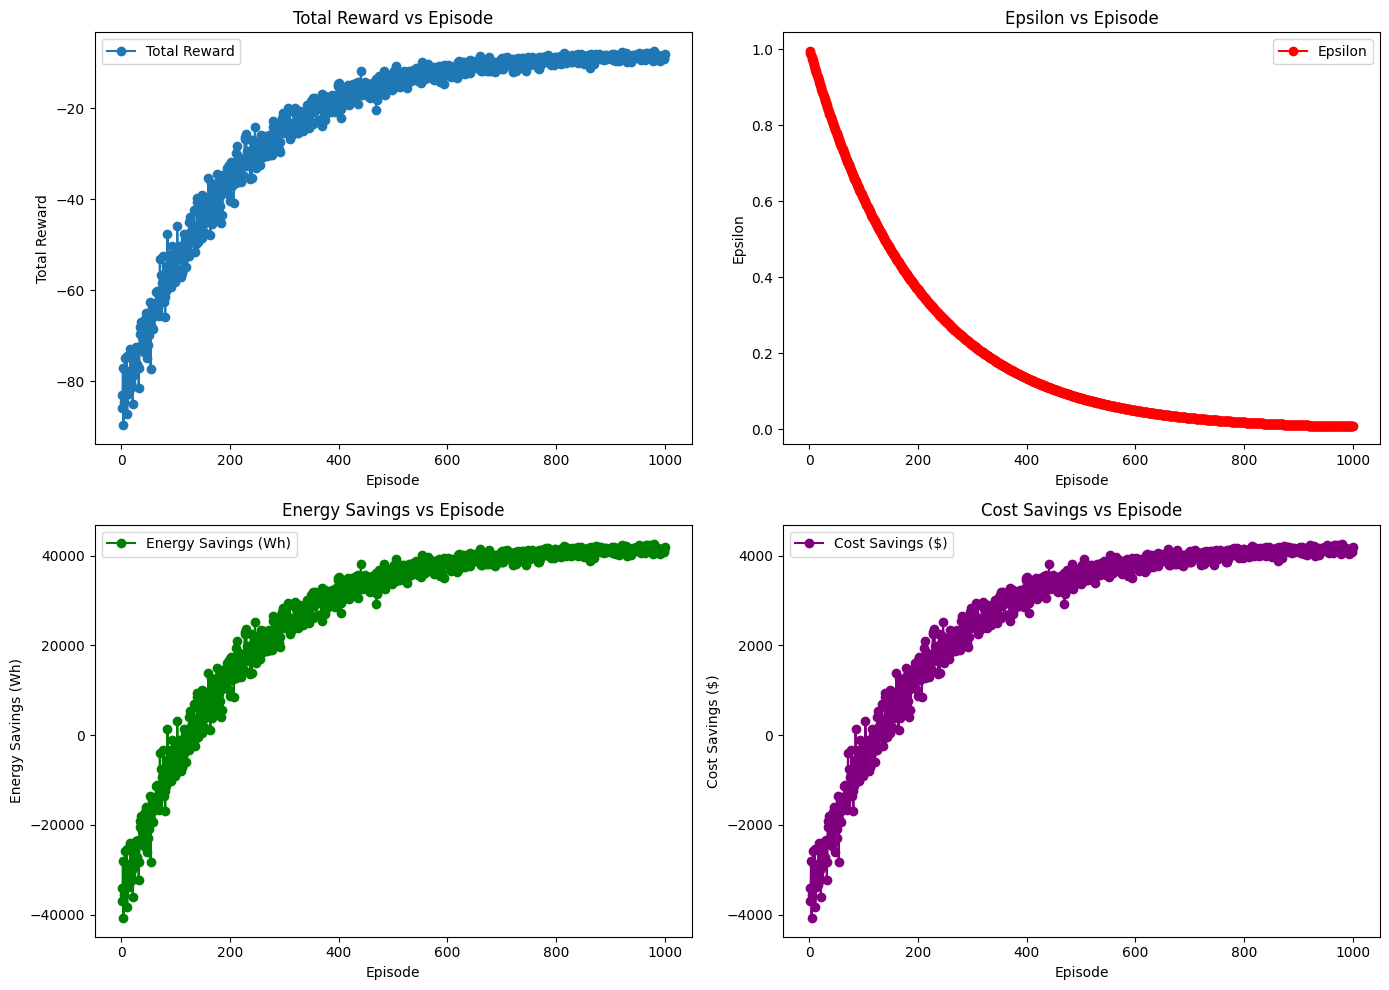

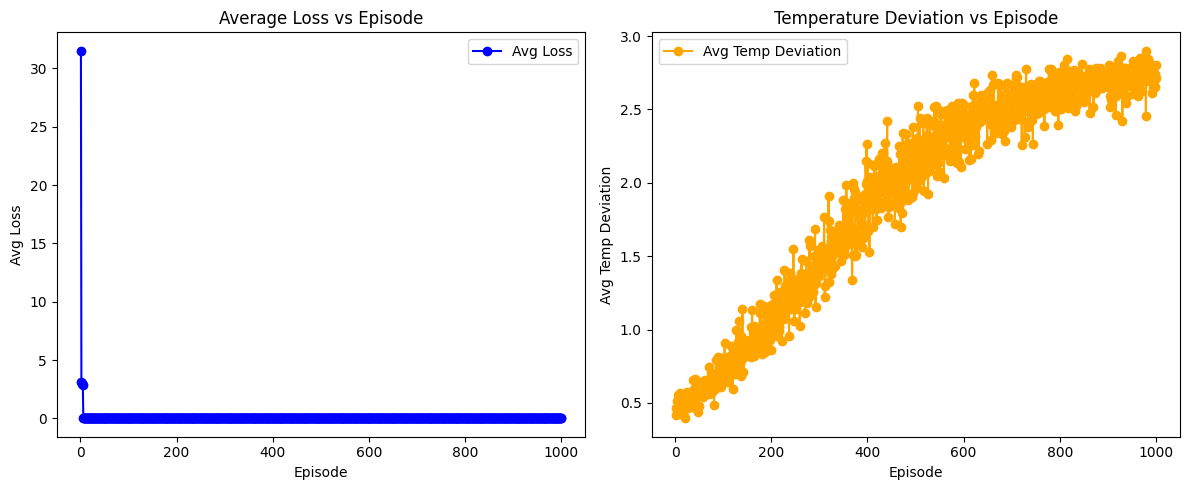

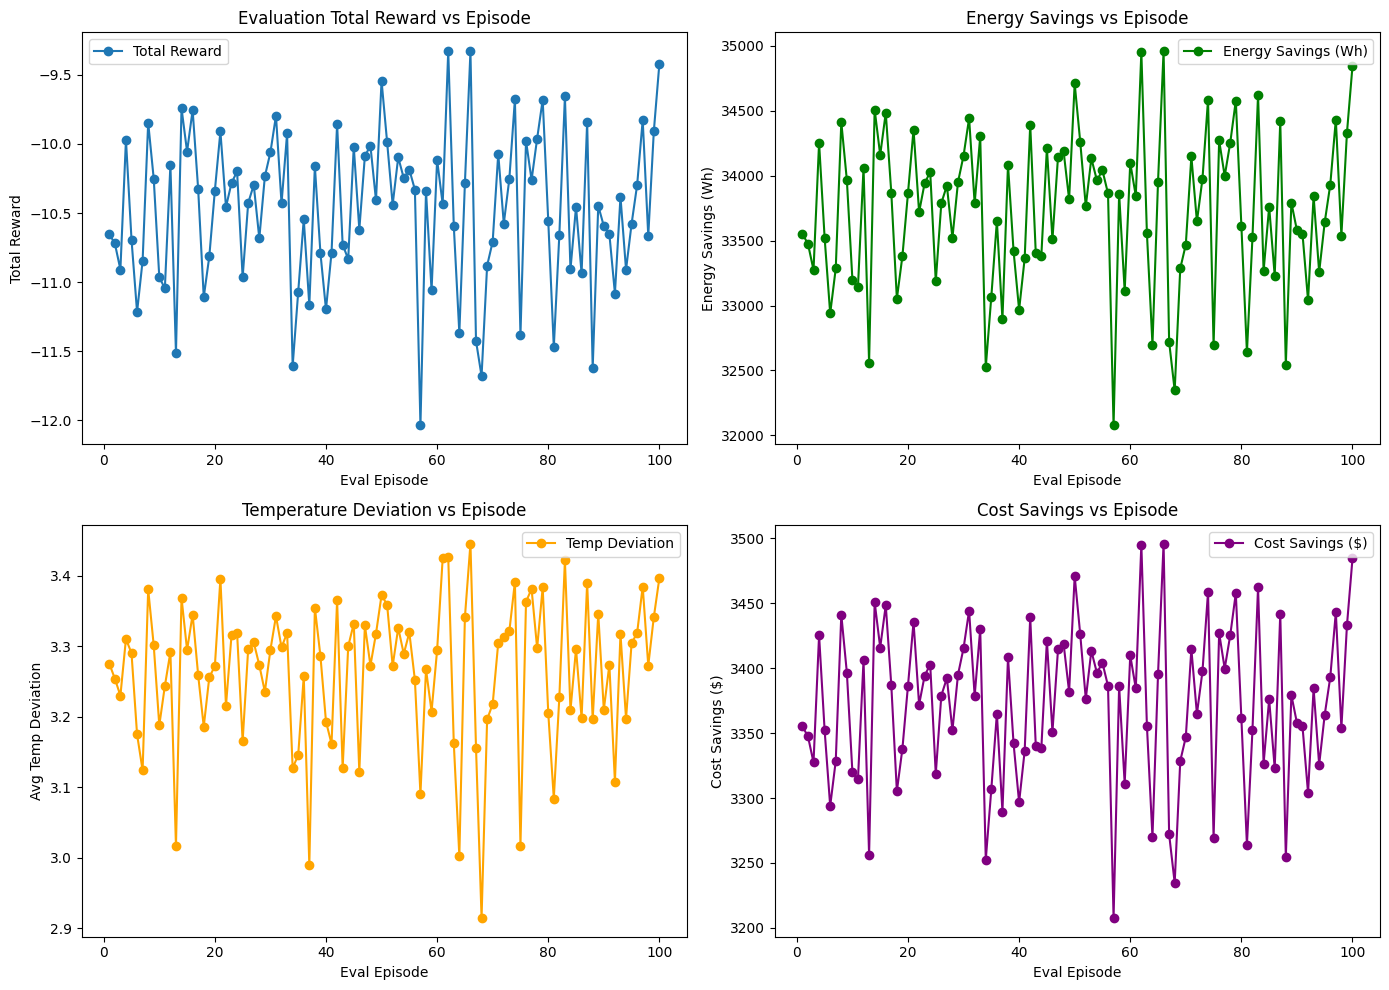

In [11]:
# =============================================================================
# 8. Main Execution
# =============================================================================
if __name__ == "__main__":
    # ------------- Load and Preprocess the Data -------------
    df = pd.read_csv("raw_data.csv")
    df = preprocess_data(df)
    
    # ------------- Data Split: 70% Train, 15% Test, 15% Validation -------------
    train_data, temp_data = train_test_split(df, test_size=0.30, random_state=42)
    test_data, val_data = train_test_split(temp_data, test_size=0.50, random_state=42)
    
    print(f"Train samples: {len(train_data)}")
    print(f"Test samples: {len(test_data)}")
    print(f"Validation samples: {len(val_data)}")
    
    # ------------- Create Environments for Each Data Split -------------
    env_train = HVACEnvironment(train_data, desired_temperature=22)
    env_test  = HVACEnvironment(test_data, desired_temperature=22)
    env_val   = HVACEnvironment(val_data, desired_temperature=22)
    
    # ------------- Initialize the DQN Agent -------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state_size = env_train.observation_space_shape
    action_size = env_train.action_space_n
    agent = DQNAgent(state_size, action_size, device)
    
    # ------------- Train the Agent on the Training Split -------------
    print("\nStarting training on training split...")
    scores, train_metrics, train_losses = train_dqn(env_train, agent, n_episodes=1000, max_t=500)
    
    # ------------- Evaluate the Trained Model -------------
    print("\nEvaluating on test split:")
    test_results = evaluate_dqn(env_test, agent, n_episodes=100, max_t=500, C_energy=0.10)
    
    print("\nEvaluating on validation split:")
    val_results = evaluate_dqn(env_val, agent, n_episodes=100, max_t=500, C_energy=0.10)
    
    # ------------- Plot the Metrics -------------
    plot_training_metrics(train_metrics, train_losses)
    plot_evaluation_metrics(test_results)